# Predicting Customer Churn 

## Business Problem

TELCO is a phone and internet company located in California. Their baseline customer churn rate over the last 6 years is 27%. They want to reduce their churn rate by 3% within the next 12-month period. In order to achieve this goal, they need an analysis of what factors contribute to churn as well as an ability to predict which customers are likely to churn.

## Business Value

On average, customers that churn have a $341 lower lifetime value to the company than those that do not churn. With a current customer base of 8,000, a 3\% reduction in churn would result in approximately an additional \\$81,840 in lifetime customer value for the company. 

## Methodology

- Analyze 6 years of customer data to look for factors that contribute to churn.
- Build a classification model to predict which customers are likely to churn. 
- Use the insights to deliver recommendations to reduce churn by 3% over the next 12-month period. 
- Create a Tableau Dashboard to summarize the results and recommendations.

Because there is no inherent risk in false positives (customers that are predicted to churn that do not), recall will be prioritized in order to maximize the number of churned customers identified.

## Obtain the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import (VotingClassifier,
                              RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier
)
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, cross_validate 
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import ClusterCentroids
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             precision_recall_curve,
                             make_scorer,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             classification_report,
                             roc_curve,
                             plot_precision_recall_curve,
                             roc_auc_score,
                             log_loss
)
import joblib
import xgboost as xgb
from xgboost import plot_importance

import os

%matplotlib inline

In [2]:
SEED = 78
CLASS_NAMES = ['not churned', 'churned']

In [3]:
df = pd.read_excel('Telco_customer_churn.xlsx')
df.head()

CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...        Contract  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...  Month-to-month   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...  Month-to-month   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...  Month-to-month   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...  Month-to-month   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...  Month-to-month   

  Paperless Billing             Payment Method  Monthly Charges Total Charges  \
0               Yes               Mailed check            53.85        108.15   
1               Yes           Electronic check            70.70        151.65   
2               Yes           Electronic check            99.65         820.5   
3               Yes           Electronic check           104.80       3046.05   
4               Yes  Bank transfer (automatic)           103.70        5036.3   

  Churn Label Churn Value Churn Score  CLTV                   Churn Reason  
0         Yes           1          86  3239   Competitor made better offer  
1         Yes           1          67  2701                          Moved  
2         Yes           1          86  5372                          Moved  
3         Yes           1          84  5003                          Moved  
4         Yes           1          89  5340  Competitor had better devices  

[5 rows x 33 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

## Data Exploration and Feature Engineering

### Helper Functions

In [5]:
def churn_by_group(df, col_to_group):
    """Takes in the dataframe and the column to group by. Returns a new
    dataframe with the churn rate per category for the indicated column."""
    
    grouped_df = df.groupby(col_to_group)[['Count','Churn Value']].sum()
    grouped_df['churn_rate'] = round(
        grouped_df['Churn Value']/grouped_df['Count'],
        2
    )
    grouped_df.sort_values(
        'churn_rate', 
        inplace=True, 
        ascending=False
    )
    return grouped_df

In [6]:
#Examine the target churn label column
df['Churn Label'].value_counts(normalize=True)

#27% of the customers churned during this interval; this is an
#unbalanced class problem

No     0.73463
Yes    0.26537
Name: Churn Label, dtype: float64

In [7]:
#Examine the target churn value column
df['Churn Value'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn Value, dtype: float64

In [8]:
#Examine the CLTV column
df['CLTV'].describe()

count    7043.000000
mean     4400.295755
std      1183.057152
min      2003.000000
25%      3469.000000
50%      4527.000000
75%      5380.500000
max      6500.000000
Name: CLTV, dtype: float64

In [9]:
#Examine the difference in lifetime value based on churn status
df.groupby('Churn Label')['CLTV'].mean()

Churn Label
No     4490.921337
Yes    4149.414660
Name: CLTV, dtype: float64

In [10]:
#Examine the target churn reason column
df['Churn Reason'].value_counts()

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Long distance charges                         44
Limited range of services                     44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

In [11]:
#Examine the zip code column
df['Zip Code'].value_counts(normalize=True)

92139    0.000710
91306    0.000710
90602    0.000710
90502    0.000710
90402    0.000710
           ...   
92335    0.000568
95385    0.000568
92339    0.000568
92347    0.000568
95531    0.000568
Name: Zip Code, Length: 1652, dtype: float64

In [12]:
#find the zip codes with the highest churn rates
churn_rate_by_zip = churn_by_group(df, 'Zip Code')
churn_rate_by_zip

Count  Churn Value  churn_rate
Zip Code                                
96161         4            4         1.0
95567         4            4         1.0
93528         4            4         1.0
93711         4            4         1.0
94014         4            4         1.0
...         ...          ...         ...
94922         4            0         0.0
94929         4            0         0.0
94930         4            0         0.0
92352         4            0         0.0
95012         4            0         0.0

[1652 rows x 3 columns]

In [13]:
churn_rate_by_zip.to_excel('churn_rate_by_zip.xlsx')

In [14]:
#Examine the city column
df['City'].value_counts(normalize=True)

Los Angeles        0.043305
San Diego          0.021298
San Jose           0.015902
Sacramento         0.015334
San Francisco      0.014766
                     ...   
Laton              0.000568
Mountain Center    0.000568
New Cuyama         0.000568
Orinda             0.000568
Grover Beach       0.000568
Name: City, Length: 1129, dtype: float64

In [15]:
#find the cities with the highest churn rates
churn_rate_by_city = churn_by_group(df, 'City')
churn_rate_by_city[:20]

Count  Churn Value  churn_rate
City                                            
Fort Jones            4            4        1.00
Eldridge              4            4        1.00
Maricopa              4            4        1.00
Boulder Creek         4            4        1.00
Riverbank             4            4        1.00
Twain                 4            4        1.00
Johannesburg          4            4        1.00
Smith River           4            4        1.00
Tipton                4            4        1.00
Wrightwood            4            4        1.00
South Lake Tahoe      4            4        1.00
Truckee               4            4        1.00
Indian Wells          5            4        0.80
Panorama City         5            4        0.80
Seeley                5            4        0.80
San Dimas             5            4        0.80
Byron                 4            3        0.75
Rio Dell              4            3        0.75
Running Springs       4            3        0.75
Quincy                4            3        0.75

In [16]:
#Examine the gender column
df['Gender'].value_counts(normalize=True)

#Male and female customers are evenly split

Male      0.504756
Female    0.495244
Name: Gender, dtype: float64

In [17]:
#Convert gender to a binary where 0=female and 1=male
df['Gender'].replace(to_replace={'Female':0, 'Male':1}, inplace=True)

In [18]:
#Examine the senior citizen column
df['Senior Citizen'].value_counts(normalize=True)

#16% are senior

No     0.837853
Yes    0.162147
Name: Senior Citizen, dtype: float64

In [19]:
#Convert gender to a binary where 0=no and 1=1
df['Senior Citizen'].replace(to_replace={'No':0, 'Yes':1}, inplace=True)

In [20]:
#Examine the partner column
df['Partner'].value_counts(normalize=True)

#Approximately half of the customers are in a relationship

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

In [21]:
#Convert partner to a binary where 0=single and 1=partnered
df['Partner'].replace(to_replace={'No':0, 'Yes':1}, inplace=True)

In [22]:
#Examine the dependents column
df['Dependents'].value_counts(normalize=True)

#Approximately 30% of the customers have children

No     0.76899
Yes    0.23101
Name: Dependents, dtype: float64

In [23]:
#Convert dependents to a binary where 0=no children and 1=children
df['Dependents'].replace(to_replace={'No':0, 'Yes':1}, inplace=True)

In [24]:
#Examine the tenure column
df['Tenure Months'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Tenure Months, dtype: float64

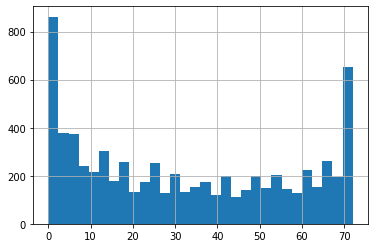

In [25]:
df['Tenure Months'].hist(bins=30);

In [26]:
df['Tenure Months'].value_counts()[:5]

1     613
72    362
2     238
3     200
4     176
Name: Tenure Months, dtype: int64

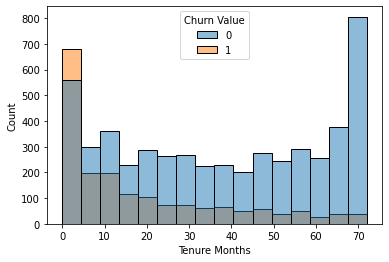

In [27]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Value');

The distribution is bimodal, with the most common values at 1 month and 72 months. This suggests that customers either leave within the first month or stay for the long term. From a business perspective, it may make sense to investigate if the factors that lead to churn differ for the group that leaves right away versus the group that leaves after a time.

In [28]:
#Create a binary column for tenure, more_than_year
def more_than_year(months):
    if months < 12:
        return 0
    else:
        return 1

df['more_than_year'] = df['Tenure Months'].apply(more_than_year)

In [29]:
#Examine churn rate based on tenure
churn_rate_by_tenure = churn_by_group(df, 'more_than_year')
churn_rate_by_tenure[:20]

Count  Churn Value  churn_rate
more_than_year                                
0                2069          999        0.48
1                4974          870        0.17

In [30]:
#Examine the phone service column
df['Phone Service'].value_counts(normalize=True)

#Approximately 90% of the customers have phone service

Yes    0.903166
No     0.096834
Name: Phone Service, dtype: float64

In [31]:
#Convert phone service to a binary where 0=no and 1=yes
df['Phone Service'].replace(to_replace={'No':0, 'Yes':1}, inplace=True)

In [32]:
#Examine the multiple lines column
df['Multiple Lines'].value_counts(normalize=True)

#Approximately 47% of the customers that have phone serive have multiple lines

No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: Multiple Lines, dtype: float64

In [33]:
#Convert multiple lines to a binary where 0=no and 1=yes
df['Multiple Lines'].replace(
    to_replace={'No':0, 'Yes':1, 'No phone service':0}, 
    inplace=True
)

In [34]:
#Examine the internet service column
df['Internet Service'].value_counts(normalize=True)

#The customers are split between fiber optic, DSL and no internet

Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: Internet Service, dtype: float64

In [35]:
#Create a new column, internet, with 0 for No and 1 for Yes
df['internet'] = df['Internet Service']
df['internet'].replace(
    to_replace={'No':0, 'Fiber optic':1, 'DSL':1}, 
    inplace=True
)

In [36]:
churn_by_group(df, 'internet')

Count  Churn Value  churn_rate
internet                                
1          5517         1756        0.32
0          1526          113        0.07

In [37]:
#Create a new column, fiber, with 0 for No and 1 for Yes
df['fiber'] = df['Internet Service']
df['fiber'].replace(
    to_replace={'No':0, 'Fiber optic':1, 'DSL':0}, 
    inplace=True
)

In [38]:
churn_by_group(df, 'fiber')

Count  Churn Value  churn_rate
fiber                                
1       3096         1297        0.42
0       3947          572        0.14

In [39]:
#Examine the online security column
df['Online Security'].value_counts(normalize=True)

No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: Online Security, dtype: float64

In [40]:
#Convert online security to a binary where 0=no and 1=yes
df['Online Security'].replace(
    to_replace={'No':0, 'Yes':1, 'No internet service':0}, 
    inplace=True
)

In [41]:
#Examine the online backup column
df['Online Backup'].value_counts(normalize=True)

No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: Online Backup, dtype: float64

In [42]:
#Convert online backup to a binary where 0=no and 1=yes
df['Online Backup'].replace(
    to_replace={'No':0, 'Yes':1, 'No internet service':0}, 
    inplace=True
)

In [43]:
#Examine the device protection column
df['Device Protection'].value_counts(normalize=True)

No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: Device Protection, dtype: float64

In [44]:
#Convert device protection to a binary where 0=no and 1=yes
df['Device Protection'].replace(
    to_replace={'No':0, 'Yes':1, 'No internet service':0}, 
    inplace=True
)

In [45]:
#Examine the tech support column
df['Tech Support'].value_counts(normalize=True)

No                     0.493114
Yes                    0.290217
No internet service    0.216669
Name: Tech Support, dtype: float64

In [46]:
#Convert tech support to a binary where 0=no and 1=yes
df['Tech Support'].replace(
    to_replace={'No':0, 'Yes':1, 'No internet service':0}, 
    inplace=True
)

In [47]:
#Create new column, extra, indicating if the customer has additional services
df['extra'] = (
    df['Online Security'] + 
    df['Online Backup'] + 
    df['Device Protection'] + 
    df['Tech Support']
)
df.loc[df.extra > 1, 'extra'] = 1

In [48]:
churn_rate_extra_services = churn_by_group(df, 'extra')
churn_rate_extra_services

Count  Churn Value  churn_rate
extra                                
0       2793          831        0.30
1       4250         1038        0.24

In [49]:
#Examine the streaming TV column
df['Streaming TV'].value_counts(normalize=True)

No                     0.398978
Yes                    0.384353
No internet service    0.216669
Name: Streaming TV, dtype: float64

In [50]:
#Convert streaming TV to a binary where 0=no and 1=yes
df['Streaming TV'].replace(
    to_replace={'No':0, 'Yes':1, 'No internet service':0}, 
    inplace=True
)

In [51]:
#Examine the streaming movies column
df['Streaming Movies'].value_counts(normalize=True)

No                     0.395428
Yes                    0.387903
No internet service    0.216669
Name: Streaming Movies, dtype: float64

In [52]:
#Convert streaming movies to a binary where 0=no and 1=yes
df['Streaming Movies'].replace(
    to_replace={'No':0, 'Yes':1, 'No internet service':0}, 
    inplace=True
)

In [53]:
#Create a new column, streaming, which is 1 if any streaming service
df['streaming'] = df['Streaming Movies'] + df['Streaming TV']
df['streaming'].replace(2,1, inplace=True)

In [54]:
churn_by_group(df, 'streaming')

Count  Churn Value  churn_rate
streaming                                
1           3499         1061        0.30
0           3544          808        0.23

In [55]:
#Examine the contract column
df['Contract'].value_counts(normalize=True)

Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: Contract, dtype: float64

In [56]:
#Examine relationship between contract type and churn
churn_rate_contract = churn_by_group(df, 'Contract')
churn_rate_contract['contract_rate'] = round(
    churn_rate_contract['Count']/churn_rate_contract['Count'].sum(),
    2
    )
churn_rate_contract

Count  Churn Value  churn_rate  contract_rate
Contract                                                     
Month-to-month   3875         1655        0.43           0.55
One year         1473          166        0.11           0.21
Two year         1695           48        0.03           0.24

As expected, there appears to be a correlation between contract type and churn rate. 

In [57]:
#Examine the paperless billing column
df['Paperless Billing'].value_counts(normalize=True)

Yes    0.592219
No     0.407781
Name: Paperless Billing, dtype: float64

In [58]:
#Convert paperless billing to a binary where 0=no and 1=yes
df['Paperless Billing'].replace(
    to_replace={'No':0, 'Yes':1}, 
    inplace=True
)

In [59]:
#Examine the payment method column
df['Payment Method'].value_counts(normalize=True)

Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: Payment Method, dtype: float64

In [60]:
#Create a new column, automatic payment, with 0 for No and 1 for Yes
df['auto_payment'] = df['Payment Method']
df['auto_payment'].replace(
    to_replace={'Electronic check':0, 
                'Mailed check':0, 
                'Bank transfer (automatic)':1,
                'Credit card (automatic)':1}, 
    inplace=True
)

In [61]:
churn_by_group(df, 'auto_payment')

Count  Churn Value  churn_rate
auto_payment                                
0              3977         1379        0.35
1              3066          490        0.16

In [62]:
#Examine the monthly charges column
df['Monthly Charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: Monthly Charges, dtype: float64

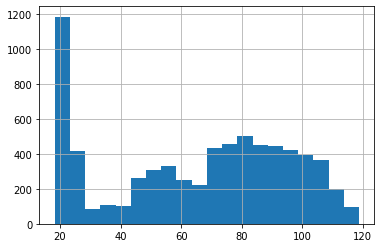

In [63]:
df['Monthly Charges'].hist(bins=20);

In [64]:
#Check if monthly charges correlates with internet service
df.groupby('internet')['Monthly Charges'].mean()

internet
0    21.079194
1    76.844254
Name: Monthly Charges, dtype: float64

<AxesSubplot:xlabel='Tenure Months', ylabel='Monthly Charges'>

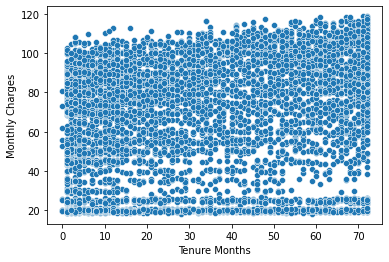

In [65]:
#Check if monthly charges correlates with tenure
sns.scatterplot(data=df, x='Tenure Months', y='Monthly Charges')

Customers with internet service pay an average of \\$76.84, whereas customers without internet pay an average of \\$21.08 per month. There does not seem to be a correlation with tenure and monthly bill.

In [66]:
#Check if monthly charges correlates with churn
df.groupby('Churn Value')['Monthly Charges'].mean()

Churn Value
0    61.265124
1    74.441332
Name: Monthly Charges, dtype: float64

Customers that cancel have bills that are \\$13.18 higher per month, on average. 

In [67]:
#Change the total charges column to a float, replacing missing values with 0
df['Total Charges'] = df['Total Charges'].replace(' ', 0)
df['Total Charges'] = df['Total Charges'].astype('float')

In [68]:
#Examine the total charges column
df['Total Charges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: Total Charges, dtype: float64

In [69]:
#Create a new column, average per month, using total charges and tenure
df['avg_per_month'] = round(df['Total Charges']/df['Tenure Months'])
df['avg_per_month'].describe()

count    7032.000000
mean       64.803185
std        30.185092
min        14.000000
25%        36.000000
50%        70.000000
75%        90.000000
max       121.000000
Name: avg_per_month, dtype: float64

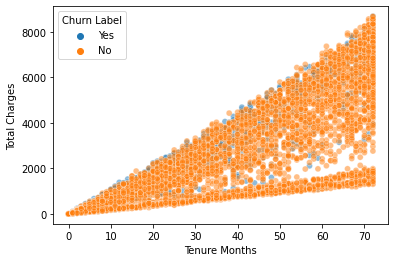

In [70]:
#Check how total charges correlate with tenure
sns.scatterplot(
    data=df, 
    x='Tenure Months', 
    y='Total Charges', 
    hue='Churn Label', 
    alpha=.5
);

In [71]:
df.head()

CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...  Churn Score  \
0  33.964131, -118.272783  33.964131 -118.272783       1  ...           86   
1   34.059281, -118.30742  34.059281 -118.307420       0  ...           67   
2  34.048013, -118.293953  34.048013 -118.293953       0  ...           86   
3  34.062125, -118.315709  34.062125 -118.315709       0  ...           84   
4  34.039224, -118.266293  34.039224 -118.266293       1  ...           89   

   CLTV                   Churn Reason  more_than_year  internet  fiber extra  \
0  3239   Competitor made better offer               0         1      0     1   
1  2701                          Moved               0         1      1     0   
2  5372                          Moved               0         1      1     1   
3  5003                          Moved               1         1      1     1   
4  5340  Competitor had better devices               1         1      1     1   

   streaming  auto_payment  avg_per_month  
0          0             0           54.0  
1          0             0           76.0  
2          1             0          103.0  
3          1             0          109.0  
4          1             1          103.0  

[5 rows x 40 columns]

In [72]:
df.to_csv('churn_data.csv')

# Preparation for Modeling

In [73]:
X = df.copy()
X.drop(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long','Churn Label', 'Churn Value','Churn Score', 'CLTV', 
        'Churn Reason'], axis=1, inplace=True)
y = df['Churn Value']

In [74]:
X_train, X_, y_train, y_ = train_test_split(
    X,
    y, 
    random_state=42, 
    test_size=.30
)
X_val, X_test, y_val, y_test = train_test_split(
    X_,
    y_,
    random_state=42,
    test_size=.5
)

In [75]:
#Identify categorical and numeric columns in X_train.
cat_cols = X_train.select_dtypes('object').columns 
num_cols = X_train.select_dtypes('number').columns

#One hot encode the categorical features and scale the numeric features.
num_transformer = Pipeline([('scale', StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore',
sparse=False))])

transformer = ColumnTransformer([ 
    (
        'num', num_transformer, num_cols
    ), 
    (
        'cat', cat_transformer, cat_cols
    ) 
])

#Create and apply a pipeline to preprocess the data
preprocess = Pipeline([('transformer', transformer)]) 

X_train_processed = preprocess.fit_transform(X_train)
X_train_processed_df = pd.DataFrame(X_train_processed)
X_val_processed = preprocess.transform(X_val)
X_val_processed_df = pd.DataFrame(X_val_processed)
X_test_processed = preprocess.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed)

cat_names = (preprocess.named_steps['transformer'] 
             .transformers_[1][1].named_steps['ohe']
            .get_feature_names(cat_cols)) 
feature_names = list(num_cols) + list(cat_names)

X_train_processed_df.columns = feature_names
X_val_processed_df.columns = feature_names
X_test_processed_df.columns = feature_names

In [76]:
#Inital feature selection

cols_to_drop = ['Streaming TV', 'Streaming Movies',
        'Paperless Billing','Total Charges', 'avg_per_month',
        'Internet Service_DSL', 'more_than_year',
        'Internet Service_Fiber optic', 'Internet Service_No',
        'Payment Method_Bank transfer (automatic)',
        'Payment Method_Credit card (automatic)',
        'Payment Method_Electronic check', 'Payment Method_Mailed check',
        'Online Security', 'Online Backup', 'Device Protection', 
        'Tech Support']

X_train_processed_df.drop(cols_to_drop, axis=1, inplace=True)
X_val_processed_df.drop(cols_to_drop, axis=1, inplace=True)
X_test_processed_df.drop(cols_to_drop, axis=1, inplace=True)

Because of the unbalanced classes, a resampling technique, such as SMOTE, may need to be applied in order to obtain satisfactory results. However, I am going to first determine if using balanced classes as a hyperparameter is sufficient in an attempt to avoid working with synthetic data. 

# Modeling

As mentioned before, the goal is to optimize for recall in order to identify as many of the churned customers as possible. 

## Helper Functions

In [77]:
#A dictionary with the basic classification algorithms.
clf_dict = {
    'baseline': DummyClassifier(
        random_state=SEED,
        strategy='stratified'
    ), 
    'log_r': LogisticRegression(
        class_weight='balanced',
        max_iter=2000
    ),
    'knn': KNeighborsClassifier(
        n_jobs=-2
    ),
    'svc': SVC(
        random_state=SEED,
        class_weight='balanced'
    ), 
    'forest': RandomForestClassifier(
        random_state=SEED, 
        n_jobs=-2, 
        class_weight='balanced'
    ),
    'GB_clf': GradientBoostingClassifier(
        random_state=SEED
    ), 
    'ada': AdaBoostClassifier(
        random_state=SEED
    ),
    'xgb': xgb.XGBClassifier(
        random_state=SEED,
        scale_pos_weight=3
    )
}
# A dictionary with the scoring methods for model evaluation.
scoring = {'AUC': 'roc_auc',
           'Accuracy': make_scorer(accuracy_score), 
           'Recall': make_scorer(recall_score), 
           'Precision': make_scorer(precision_score), 
           'F1': make_scorer(f1_score)}

In [78]:
screen_dict = {}

def screen_model(clf, clf_dict, scoring, X, y):
    """Takes in the classifier key from the classifier dictionary, the classifier 
    dictionary, a scoring dictionary and an X and y and runs a 5-fold
    cross_validation. The scores are reported and added to a dictionary."""

    clf_screen = {}
    score = cross_validate(
        clf_dict[clf], 
        X,
        y,
        scoring=scoring,
        cv=5, 
        return_train_score=True, 
        n_jobs=-2
    )
    for k,v in score.items(): 
        clf_screen[f'{k} mean'] = v.mean() 
        clf_screen[f'{k} std'] = v.std()
        screen_dict[clf] = clf_screen 
    return screen_dict[clf]

In [79]:
report_dict = {}

def get_pred(clf, clf_dict, X_train, y_train, X_val, y_val):
    """Takes in a classifier, the classifier dictionary, the train and 
    validation sets and returns the predicted y values on the validation set."""
    clf = clf_dict[clf]
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    return y_val_pred

def get_report(clf, clf_dict, X_train, y_train, X_val, y_val):
    """Takes in a classifier, the classifier dictionary, the train and 
    validation sets and returns the classifation report for the validation set."""
    y_val_pred = get_pred(clf, clf_dict, X_train, y_train, X_val, y_val) 
    report = classification_report(y_val, y_val_pred, output_dict=True) 
    report_dict[clf] = report
    report = pd.DataFrame(report).T
    return report

In [80]:
baseline = screen_model('baseline', clf_dict, scoring, X_train_processed_df, y_train) 
screen_dict['baseline'] = baseline
screen_dict['baseline']

{'fit_time mean': 0.0015225887298583984,
 'fit_time std': 0.00018860018175532236,
 'score_time mean': 0.007120800018310547,
 'score_time std': 0.0007891593080030176,
 'test_AUC mean': 0.501431479597356,
 'test_AUC std': 0.011260595222579708,
 'train_AUC mean': 0.503333406813998,
 'train_AUC std': 0.0024549648952175433,
 'test_Accuracy mean': 0.6196754563894523,
 'test_Accuracy std': 0.0087480156806685,
 'train_Accuracy mean': 0.6221095334685598,
 'train_Accuracy std': 0.001961367099981125,
 'test_Recall mean': 0.2552589980544747,
 'test_Recall std': 0.016324628844837718,
 'train_Recall mean': 0.2560503048780488,
 'train_Recall std': 0.003546664831182556,
 'test_Precision mean': 0.26204516129032257,
 'test_Precision std': 0.017293158169024454,
 'train_Precision mean': 0.2649448273326334,
 'train_Precision std': 0.00372894293369556,
 'test_F1 mean': 0.2586060345164951,
 'test_F1 std': 0.016787831807429543,
 'train_F1 mean': 0.2604215973997286,
 'train_F1 std': 0.003634254982548072}

In [81]:
log_r_file = 'files/log_r.pk1'
if 'log_r.pk1' in os.listdir('files'):
    log_r = joblib.load(log_r_file) 
else:
    log_r = screen_model('log_r', clf_dict,
                         scoring,
                         X_train_processed_df,
                         y_train)
    joblib.dump(log_r, log_r_file) 
screen_dict['log_r'] = log_r 
screen_dict['log_r']

{'fit_time mean': 0.030220174789428712,
 'fit_time std': 0.0055597163652546305,
 'score_time mean': 0.009377145767211914,
 'score_time std': 0.002193083953220626,
 'test_AUC mean': 0.8505460688257219,
 'test_AUC std': 0.015825272575848606,
 'train_AUC mean': 0.8539449858504249,
 'train_AUC std': 0.003944770975975612,
 'test_Accuracy mean': 0.7549695740365112,
 'test_Accuracy std': 0.0140326414250937,
 'train_Accuracy mean': 0.7575050709939148,
 'train_Accuracy std': 0.004615997382444357,
 'test_Recall mean': 0.7986107733463035,
 'test_Recall std': 0.04017342249937112,
 'train_Recall mean': 0.7997654344512195,
 'train_Recall std': 0.0070292723625875065,
 'test_Precision mean': 0.5184857146155795,
 'test_Precision std': 0.017789242302288788,
 'train_Precision mean': 0.5217981357990397,
 'train_Precision std': 0.005922882472317401,
 'test_F1 mean': 0.6285579997603579,
 'test_F1 std': 0.02330015848430075,
 'train_F1 mean': 0.6315416643282803,
 'train_F1 std': 0.00620305315672292}

In [82]:
log_r_report = get_report('log_r', clf_dict,
           X_train_processed_df,
           y_train,
           X_val_processed_df,
           y_val)
log_r_report

precision    recall  f1-score      support
0              0.907131  0.725464  0.806190   754.000000
1              0.543046  0.814570  0.651656   302.000000
accuracy       0.750947  0.750947  0.750947     0.750947
macro avg      0.725089  0.770017  0.728923  1056.000000
weighted avg   0.803008  0.750947  0.761996  1056.000000

In [83]:
knn_file = 'files/knn.pk1'
if 'knn.pk1' in os.listdir('files'):
    knn = joblib.load(knn_file) 
else:
    knn = screen_model('knn', 
                       clf_dict,
                       scoring,
                       X_train_processed_df,
                       y_train
                      )
    joblib.dump(knn, knn_file) 
screen_dict['knn'] = knn 
screen_dict['knn']

{'fit_time mean': 0.022034406661987305,
 'fit_time std': 0.014843465603375499,
 'score_time mean': 0.20246191024780275,
 'score_time std': 0.07244375490584415,
 'test_AUC mean': 0.7667874358502773,
 'test_AUC std': 0.014339190567669557,
 'train_AUC mean': 0.8983204906399983,
 'train_AUC std': 0.0023698492325220154,
 'test_Accuracy mean': 0.7531440162271805,
 'test_Accuracy std': 0.009152546996088015,
 'train_Accuracy mean': 0.8377281947261663,
 'train_Accuracy std': 0.0013979765468651376,
 'test_Recall mean': 0.45512220330739306,
 'test_Recall std': 0.015195666487824985,
 'train_Recall mean': 0.6188513719512196,
 'train_Recall std': 0.008454616399516217,
 'test_Precision mean': 0.5295564137239628,
 'test_Precision std': 0.020812641951424155,
 'train_Precision mean': 0.7178859019684718,
 'train_Precision std': 0.006940869986975635,
 'test_F1 mean': 0.489344814553135,
 'test_F1 std': 0.015127097186036918,
 'train_F1 mean': 0.6646205355236984,
 'train_F1 std': 0.003137942499456026}

In [84]:
knn_report = get_report(
    'knn', 
    clf_dict,
    X_train_processed_df,
    y_train,
    X_val_processed_df,
    y_val
)

knn_report

precision    recall  f1-score      support
0              0.814446  0.867374  0.840077   754.000000
1              0.604743  0.506623  0.551351   302.000000
accuracy       0.764205  0.764205  0.764205     0.764205
macro avg      0.709594  0.686998  0.695714  1056.000000
weighted avg   0.754474  0.764205  0.757506  1056.000000

In [85]:
svc_file = 'files/svc.pk1'
if 'svc.pk1' in os.listdir('files'):
    svc = joblib.load(svc_file) 
else:
    svc = screen_model('svc', 
                       clf_dict, 
                       scoring,
                       X_train_processed_df,
                       y_train
                      )
    joblib.dump(svc, svc_file) 
screen_dict['svc'] = svc 
screen_dict['svc']

{'fit_time mean': 0.6012678146362305,
 'fit_time std': 0.007305481202043072,
 'score_time mean': 0.13319621086120606,
 'score_time std': 0.0027435747569382234,
 'test_AUC mean': 0.8387668610958114,
 'test_AUC std': 0.015949473218888476,
 'train_AUC mean': 0.8824738358295289,
 'train_AUC std': 0.002291615552102933,
 'test_Accuracy mean': 0.7494929006085193,
 'test_Accuracy std': 0.019178818099103934,
 'train_Accuracy mean': 0.7781947261663286,
 'train_Accuracy std': 0.004095906796411504,
 'test_Recall mean': 0.7923546935797665,
 'test_Recall std': 0.041782861678647545,
 'train_Recall mean': 0.8411406249999999,
 'train_Recall std': 0.00791793477445614,
 'test_Precision mean': 0.512014774799841,
 'test_Precision std': 0.02356178489459566,
 'train_Precision mean': 0.5477225541775809,
 'train_Precision std': 0.005644736458870756,
 'test_F1 mean': 0.6217267816823613,
 'test_F1 std': 0.026676514506340374,
 'train_F1 mean': 0.6633978184005569,
 'train_F1 std': 0.004241540570036403}

In [86]:
svc_report = get_report('svc', 
                        clf_dict,
                        X_train_processed_df,
                        y_train,
                        X_val_processed_df,
                        y_val
                       )
svc_report

precision    recall  f1-score      support
0              0.910473  0.714854  0.800892   754.000000
1              0.536638  0.824503  0.650131   302.000000
accuracy       0.746212  0.746212  0.746212     0.746212
macro avg      0.723555  0.769679  0.725511  1056.000000
weighted avg   0.803562  0.746212  0.757776  1056.000000

In [87]:
forest_file = 'files/forest.pk1'
if 'forest.pk1' in os.listdir('files'):
    forest = joblib.load(forest_file) 
else:
    forest = screen_model('forest', 
                         clf_dict,
                         scoring,
                         X_train_processed_df,
                         y_train
                         )
    joblib.dump(forest, forest_file) 
screen_dict['forest'] = forest 
screen_dict['forest']

{'fit_time mean': 0.4349065780639648,
 'fit_time std': 0.027530453268756427,
 'score_time mean': 0.0744412899017334,
 'score_time std': 0.00949627203638639,
 'test_AUC mean': 0.8346034544736041,
 'test_AUC std': 0.015652713130610167,
 'train_AUC mean': 1.0,
 'train_AUC std': 4.965068306494546e-17,
 'test_Accuracy mean': 0.7886409736308316,
 'test_Accuracy std': 0.016030758465297577,
 'train_Accuracy mean': 1.0,
 'train_Accuracy std': 0.0,
 'test_Recall mean': 0.4839980544747082,
 'test_Recall std': 0.013094532798696948,
 'train_Recall mean': 1.0,
 'train_Recall std': 0.0,
 'test_Precision mean': 0.6221701377013762,
 'test_Precision std': 0.04501081182187248,
 'train_Precision mean': 1.0,
 'train_Precision std': 0.0,
 'test_F1 mean': 0.54389728007215,
 'test_F1 std': 0.02298198092572498,
 'train_F1 mean': 1.0,
 'train_F1 std': 0.0}

In [88]:
forest_report = get_report('forest', 
                           clf_dict,
                           X_train_processed_df,
                           y_train,
                           X_val_processed_df,
                           y_val
                          )

forest_report

precision    recall  f1-score      support
0              0.816766  0.904509  0.858402   754.000000
1              0.674208  0.493377  0.569790   302.000000
accuracy       0.786932  0.786932  0.786932     0.786932
macro avg      0.745487  0.698943  0.714096  1056.000000
weighted avg   0.775997  0.786932  0.775863  1056.000000

In [89]:
GB_clf_file = 'files/GB_clf.pk1'
if 'GB_clf.pk1' in os.listdir('files'):
    GB_clf = joblib.load(GB_clf_file) 
else:
    GB_clf = screen_model('GB_clf', 
                          clf_dict,
                          scoring,
                          X_train_processed_df,
                          y_train
                         )
    joblib.dump(GB_clf, GB_clf_file) 
screen_dict['GB_clf'] = GB_clf 
screen_dict['GB_clf']

{'fit_time mean': 0.6582337856292725,
 'fit_time std': 0.002698031265982457,
 'score_time mean': 0.012025976181030273,
 'score_time std': 0.001078414453142712,
 'test_AUC mean': 0.8540753237638764,
 'test_AUC std': 0.014381830505513048,
 'train_AUC mean': 0.8974658229231484,
 'train_AUC std': 0.0020400263270985296,
 'test_Accuracy mean': 0.8006085192697769,
 'test_Accuracy std': 0.012180523161056741,
 'train_Accuracy mean': 0.8397058823529411,
 'train_Accuracy std': 0.002975943357225397,
 'test_Recall mean': 0.5167831955252918,
 'test_Recall std': 0.024003150820941857,
 'train_Recall mean': 0.596016768292683,
 'train_Recall std': 0.017725078282869428,
 'test_Precision mean': 0.6461404441535533,
 'test_Precision std': 0.032224654334884695,
 'train_Precision mean': 0.7368292924462144,
 'train_Precision std': 0.004021749307230873,
 'test_F1 mean': 0.5739166324632927,
 'test_F1 std': 0.023916836218598816,
 'train_F1 mean': 0.6588295190395028,
 'train_F1 std': 0.0106087673351679}

In [90]:
gb_report = get_report('GB_clf', 
                       clf_dict,
                       X_train_processed_df,
                       y_train,
                       X_val_processed_df,
                       y_val
                      )

gb_report

precision    recall  f1-score      support
0              0.844893  0.888594  0.866193   754.000000
1              0.680608  0.592715  0.633628   302.000000
accuracy       0.803977  0.803977  0.803977     0.803977
macro avg      0.762751  0.740655  0.749910  1056.000000
weighted avg   0.797910  0.803977  0.799683  1056.000000

In [91]:
ada_file = 'files/ada.pk1'
if 'ada.pk1' in os.listdir('files'):
    ada = joblib.load(ada_file) 
else:
    ada = screen_model('ada', 
                       clf_dict,
                       scoring,
                       X_train_processed_df,
                       y_train
                      )
    joblib.dump(ada, ada_file) 
screen_dict['ada'] = ada 
screen_dict['ada']

{'fit_time mean': 0.20811071395874023,
 'fit_time std': 0.004205044730990562,
 'score_time mean': 0.04150171279907226,
 'score_time std': 0.0016368734561016671,
 'test_AUC mean': 0.8478455812439144,
 'test_AUC std': 0.016604309970507353,
 'train_AUC mean': 0.8685370139384189,
 'train_AUC std': 0.0035775183382384984,
 'test_Accuracy mean': 0.8032454361054766,
 'test_Accuracy std': 0.0136822896178824,
 'train_Accuracy mean': 0.8154158215010142,
 'train_Accuracy std': 0.004116572767262141,
 'test_Recall mean': 0.5558183365758754,
 'test_Recall std': 0.036220280708082545,
 'train_Recall mean': 0.5772818216463416,
 'train_Recall std': 0.010948295435383839,
 'test_Precision mean': 0.6395879941451506,
 'test_Precision std': 0.028329916816710456,
 'train_Precision mean': 0.66743526536226,
 'train_Precision std': 0.009113562226952346,
 'test_F1 mean': 0.5944994283245008,
 'test_F1 std': 0.031253355218434,
 'train_F1 mean': 0.6190595194075231,
 'train_F1 std': 0.009276248742917308}

In [92]:
ada_report = get_report('ada', 
                        clf_dict,
                        X_train_processed_df,
                        y_train,
                        X_val_processed_df,
                        y_val
                       )

ada_report

precision    recall  f1-score     support
0              0.846447  0.884615  0.865110   754.00000
1              0.675373  0.599338  0.635088   302.00000
accuracy       0.803030  0.803030  0.803030     0.80303
macro avg      0.760910  0.741977  0.750099  1056.00000
weighted avg   0.797522  0.803030  0.799327  1056.00000

In [93]:
xgb_file = 'files/xgb.pk1'
if 'xgb.pk1' in os.listdir('files'):
    xgb = joblib.load(xgb_file) 
else:
    xgb = screen_model('xgb', 
                       clf_dict,
                    scoring,
                    X_train_processed_df,
                    y_train
                      )
    joblib.dump(xgb, xgb_file) 
screen_dict['xgb'] = xgb 
screen_dict['xgb']

{'fit_time mean': 0.7053615570068359,
 'fit_time std': 0.013122415632270387,
 'score_time mean': 0.02115473747253418,
 'score_time std': 0.0010001431611460175,
 'test_AUC mean': 0.8274329328245855,
 'test_AUC std': 0.015496650082323909,
 'train_AUC mean': 0.9993380227836937,
 'train_AUC std': 0.0002759679397072507,
 'test_Accuracy mean': 0.7663286004056795,
 'test_Accuracy std': 0.01532212370630526,
 'train_Accuracy mean': 0.9697261663286005,
 'train_Accuracy std': 0.0036588547682652158,
 'test_Recall mean': 0.6338916585603113,
 'test_Recall std': 0.018953422307224962,
 'train_Recall mean': 0.9998048780487805,
 'train_Recall std': 0.00039024390243902474,
 'test_Precision mean': 0.5440589426824415,
 'test_Precision std': 0.026058802702591293,
 'train_Precision mean': 0.8959286085375489,
 'train_Precision std': 0.011369992272608386,
 'test_F1 mean': 0.5852745746456564,
 'test_F1 std': 0.02033065786650386,
 'train_F1 mean': 0.9449822327887963,
 'train_F1 std': 0.006291982792357827}

In [94]:
xgb_report = get_report('xgb', 
                        clf_dict,
                        X_train_processed_df,
                        y_train,
                        X_val_processed_df,
                        y_val
                       )

xgb_report

precision    recall  f1-score      support
0              0.869186  0.793103  0.829404   754.000000
1              0.576087  0.701987  0.632836   302.000000
accuracy       0.767045  0.767045  0.767045     0.767045
macro avg      0.722637  0.747545  0.731120  1056.000000
weighted avg   0.785364  0.767045  0.773188  1056.000000

In [95]:
model_screen_df = pd.DataFrame(screen_dict).T

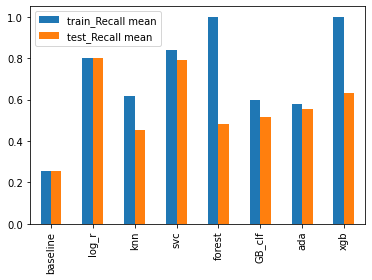

In [96]:
model_screen_df[['train_Recall mean', 'test_Recall mean']].plot(kind='bar');

Based on the results of the screening, logistic regression and SVC are performing the best overall. Not only are they showing less overfitting, they also performed well with the unbalanced classes, especially with recall. 

In [97]:
#Examine feature importances from XGBoost
xgb = clf_dict['xgb']
xgb.fit(X_train_processed_df, y_train)
pd.DataFrame(
    list(
        zip(
            X_train_processed_df.columns, 
            xgb.feature_importances_
        )
    )
).sort_values(
    1, 
    ascending=False
)

0         1
15  Contract_Month-to-month  0.437566
11                    fiber  0.131756
5                Dependents  0.106642
17        Contract_Two year  0.050155
10                 internet  0.040531
16        Contract_One year  0.037430
13                streaming  0.031018
6             Tenure Months  0.019475
7             Phone Service  0.018903
8            Multiple Lines  0.018874
12                    extra  0.016064
9           Monthly Charges  0.015610
1                 Longitude  0.013099
0                  Latitude  0.012761
14             auto_payment  0.012622
2                    Gender  0.012561
3            Senior Citizen  0.012560
4                   Partner  0.012372

Based on the feature importances, all of the selected features carry some information. If overfitting remains a problem, I will consider reducing the features further. 

In [100]:
#Hyperparameter grid for grid search
hyperparameter_dict = { 
        'xgb': [{
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 10, 15]
}], 
    'svc': [{
    'C': [.001, .01, .1, 1],
    'gamma': [1,0.1,0.001]
    }],
    'log_r': [{
        'penalty': ['l2', 'none'],
        'C': [.001, .01, .1, 1] }]
}

def tune_model(clf, clf_dict, hyperparameter_dict, scoring, X,y):
    """Takes in the model's key from the clf dictionary, a classifier dictionary, 
    a hyperparameter dictionary, a scoring dictionary and and X
     and y. A gridsearch is then performed using the
    specified classifier and its associated hyperparameters from the
    hyperparameter dictonary. After the model is fitted, a
    GridSearchCV object is then returned."""
    model = GridSearchCV(clf_dict[clf], 
                         hyperparameter_dict[clf],
                         cv=3,
                         scoring=scoring,
                         refit = 'Recall', 
                         return_train_score=True, 
                         n_jobs=-2, 
                         error_score="raise"
                        )                 
    model.fit(X,y)
    return model
                         
model_compare = {}
    
def score_model(model, clf):
    """Takes in a model and its key from the clf dictionary and returns
    a dictionary with its scoring metrics. It also appends this dictionary 
    to the model_compare dictionary."""
    model_eval_dict = {}
    model_eval_dict['train_accuracy'] = ( model.cv_results_['mean_train_Accuracy']).mean()
    model_eval_dict['test_accuracy'] = ( model.cv_results_['mean_test_Accuracy']).mean()
    model_eval_dict['AUC_train'] = ( model.cv_results_['mean_train_AUC']).mean()
    model_eval_dict['AUC_test'] = ( model.cv_results_['mean_test_AUC']).mean()
    model_eval_dict['train_f1'] = ( model.cv_results_['mean_train_F1']).mean()
    model_eval_dict['test_f1'] = ( model.cv_results_['mean_test_F1']).mean()
    model_eval_dict['train_recall'] = ( model.cv_results_['mean_train_Recall']).mean()
    model_eval_dict['test_recall'] = ( model.cv_results_['mean_test_Recall']).mean()
    model_eval_dict['train_precision'] = ( model.cv_results_['mean_train_Precision']).mean()
    model_eval_dict['test_precision'] = ( model.cv_results_['mean_test_Precision']).mean()
    model_eval_dict['best_params'] = model.best_params_ 
    for k,v in model_eval_dict.items():
        print(f"{k}: {v}") 
    model_compare[clf] = model_eval_dict
    return model_compare


In [103]:
logr_grid_file = 'files/log_r_grid.pk1'
if 'log_r_grid.pk1' in os.listdir('files'):
    log_r_grid = joblib.load(logr_grid_file) 
else:
    log_r_grid = tune_model('log_r',
                            clf_dict,
                            hyperparameter_dict,
                            scoring,
                            X_train_processed_df,
                            y_train)
    joblib.dump(log_r_grid,logr_grid_file) 
log_r_score = score_model(log_r_grid, 'log_r')

train_accuracy: 0.7571375102358573
test_accuracy: 0.7524841033428948
AUC_train: 0.8526036505331329
AUC_test: 0.8497056605838738
train_f1: 0.630625423469169
test_f1: 0.6261983764071865
train_recall: 0.7980093676814988
test_recall: 0.7985948477751756
train_precision: 0.5213006249883836
test_precision: 0.5153104707767483
best_params: {'C': 1, 'penalty': 'l2'}


In [104]:
svc_grid_file = 'files/svc_grid.pk1'
if 'svc_grid.pk1' in os.listdir('files'):
    svc_grid = joblib.load(svc_grid_file) 
else:
    svc_grid = tune_model('svc',
                            clf_dict,
                            hyperparameter_dict,
                            scoring,
                            X_train_processed_df,
                            y_train)
    joblib.dump(svc_grid,svc_grid_file) 
svc_score = score_model(svc_grid, 'svc')

train_accuracy: 0.7022772579636003
test_accuracy: 0.674688525151227
AUC_train: 0.882431131350148
AUC_test: 0.8006848140551744
train_f1: 0.44700030997301116
test_f1: 0.38581918638006796
train_recall: 0.6122170179547229
test_recall: 0.5384465261514441
train_precision: 0.3827631457495058
test_precision: 0.33691597969009396
best_params: {'C': 0.1, 'gamma': 0.001}


In [105]:
xgb_grid_file = 'files/xgb_grid.pk1'
if 'xgb_grid.pk1' in os.listdir('files'):
    xgb_grid = joblib.load(xgb_grid_file) 
else:
    xgb_grid = tune_model('xgb',
                            clf_dict,
                            hyperparameter_dict,
                            scoring,
                            X_train_processed_df,
                            y_train)
    joblib.dump(xgb_grid,xgb_grid_file) 
xgb_score = score_model(xgb_grid, 'xgb')

train_accuracy: 0.9158667566747197
test_accuracy: 0.7656427863020852
AUC_train: 0.9711742124069217
AUC_test: 0.8307866132270132
train_f1: 0.8651709793047637
test_f1: 0.5990615266501607
train_recall: 0.9648201154576383
test_recall: 0.6778442767513806
train_precision: 0.7919093990189443
test_precision: 0.5412425283005924
best_params: {'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
